In [1]:
from numpy import array
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

In [2]:
# transform a time series dataset into a supervised learning dataset
# 以n_in+n_out为一个窗口，1为单位向后移动，把一维的data，转换为二维数据
# 例如:n_in,n_out,以1为窗口，逐一向后移动
# [1,2,3,4,5,6,7,8] -> [[1,2],[2,3],[3,4],[4,5],[5,6],[6,7],[7,8]]
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

In [3]:
testData = [1,2,3,4,5,6,7,8]
test1 = series_to_supervised(testData,3)

In [4]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

In [5]:
print(test1.shape)
trans,test = train_test_split(test1,3)
print(trans.shape)
print(test.shape)

(5, 4)
(2, 4)
(3, 4)


In [6]:
# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = RandomForestRegressor(n_estimators=1000)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]

In [7]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = random_forest_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions

In [8]:
# load the dataset
series = read_csv('source/daily-total-female-births.csv', header=0, index_col=0)

In [9]:
series

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44
...,...
1959-12-27,37
1959-12-28,52
1959-12-29,48


In [10]:
values = series.values

In [11]:
print(values)
print(values.shape)
type(values)

[[35]
 [32]
 [30]
 [31]
 [44]
 [29]
 [45]
 [43]
 [38]
 [27]
 [38]
 [33]
 [55]
 [47]
 [45]
 [37]
 [50]
 [43]
 [41]
 [52]
 [34]
 [53]
 [39]
 [32]
 [37]
 [43]
 [39]
 [35]
 [44]
 [38]
 [24]
 [23]
 [31]
 [44]
 [38]
 [50]
 [38]
 [51]
 [31]
 [31]
 [51]
 [36]
 [45]
 [51]
 [34]
 [52]
 [47]
 [45]
 [46]
 [39]
 [48]
 [37]
 [35]
 [52]
 [42]
 [45]
 [39]
 [37]
 [30]
 [35]
 [28]
 [45]
 [34]
 [36]
 [50]
 [44]
 [39]
 [32]
 [39]
 [45]
 [43]
 [39]
 [31]
 [27]
 [30]
 [42]
 [46]
 [41]
 [36]
 [45]
 [46]
 [43]
 [38]
 [34]
 [35]
 [56]
 [36]
 [32]
 [50]
 [41]
 [39]
 [41]
 [47]
 [34]
 [36]
 [33]
 [35]
 [38]
 [38]
 [34]
 [53]
 [34]
 [34]
 [38]
 [35]
 [32]
 [42]
 [34]
 [46]
 [30]
 [46]
 [45]
 [54]
 [34]
 [37]
 [35]
 [40]
 [42]
 [58]
 [51]
 [32]
 [35]
 [38]
 [33]
 [39]
 [47]
 [38]
 [52]
 [30]
 [34]
 [40]
 [35]
 [42]
 [41]
 [42]
 [38]
 [24]
 [34]
 [43]
 [36]
 [55]
 [41]
 [45]
 [41]
 [37]
 [43]
 [39]
 [33]
 [43]
 [40]
 [38]
 [45]
 [46]
 [34]
 [35]
 [48]
 [51]
 [36]
 [33]
 [46]
 [42]
 [48]
 [34]
 [41]
 [35]
 [40]
 [34

numpy.ndarray

In [12]:
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)

In [13]:
data

array([[35., 32., 30., ..., 44., 29., 45.],
       [32., 30., 31., ..., 29., 45., 43.],
       [30., 31., 44., ..., 45., 43., 38.],
       ...,
       [40., 38., 44., ..., 37., 52., 48.],
       [38., 44., 34., ..., 52., 48., 55.],
       [44., 34., 37., ..., 48., 55., 50.]])

In [14]:
data.shape

(359, 7)

In [15]:
# evaluate
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)

>expected=42.0, predicted=45.2
>expected=53.0, predicted=43.8
>expected=39.0, predicted=41.6
>expected=40.0, predicted=38.3
>expected=38.0, predicted=43.2
>expected=44.0, predicted=47.6
>expected=34.0, predicted=42.2
>expected=37.0, predicted=36.9
>expected=52.0, predicted=38.3
>expected=48.0, predicted=42.0
>expected=55.0, predicted=43.7
>expected=50.0, predicted=45.3
MAE: 5.795


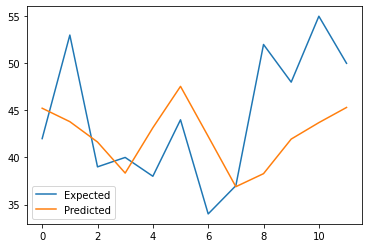

In [16]:
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()